<a href="https://novoic.com"><img src="https://novoic.com/wp-content/uploads/2019/10/logo_320px.png" alt="Novoic logo" width="160"/></a>

# Novoic ML challenge – text data

## Introduction
Welcome to the Novoic ML challenge!

This is an open-ended ML challenge to help us identify exceptional researchers and engineers. The guidance below describes an open-source dataset that you can use to demonstrate your research skills, creativity, coding ability, scientific communication or anything else you think is important to the role.

Before starting the challenge, go ahead and read our CEO's [Medium post](https://medium.com/@emil_45669/the-doctor-is-ready-to-see-you-tube-videos-716b12367feb) on what we're looking for in our Research Scientists, Research Engineers and ML Interns. We recommend you spend around three hours on this (more or less if you wish), which you do not have to do in one go. Please make use of any resources you like.

This is the text version of the challenge. Also available are audio and image versions. You can access all three from [this GitHub repo](https://github.com/novoic/ml-challenge).

Best of luck – we're looking forward to seeing what you can do!

## Prepare the data
Copy the dataset to a local directory – this should take a few seconds.

In [1]:
!mkdir -p data
!gsutil -m cp -r gs://novoic-ml-challenge-text-data/* ./data

Copying gs://novoic-ml-challenge-text-data/LICENSE...
Copying gs://novoic-ml-challenge-text-data/README.md...
Copying gs://novoic-ml-challenge-text-data/data.txt...
/ [3/3 files][468.7 KiB/468.7 KiB] 100% Done                                    
Operation completed over 3 objects/468.7 KiB.                                    


## Data description

The data comprises 5,574 SMS messages. Each message is labelled as either 'ham' (legitimate) or spam.

Each line in `data.txt` corresponds to one message. The first word is the data label (either `ham` or `spam`), followed by a tab (`\t`) character and then the message.

In [0]:
with open('data/data.txt', 'r') as f:
    msgs = f.read().splitlines()

In [3]:
print(msgs[10])
print(msgs[11])

ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info



For more information about the dataset, see its `README.md`.

Directory structure:
```
data/
├── data.txt
├── LICENSE
└── README.md
```






## The challenge
This is an open-ended challenge and we want to witness your creativity. Some suggestions:
- Data exploration/visualization
- Binary classification
- Unsupervised clustering
- Model explainability

You're welcome to explore one or more of these topics, or do something entirely different.

Create, iterate on, and validate your work in this notebook, using any packages of your choosing.

**You can access a GPU via `Runtime -> Change runtime type` in the toolbar.**

## Submission instructions
Once you're done, send this `.ipynb` notebook (or a link to it hosted on Google Drive/GitHub with appropriate permissions) to talent@novoic.com, ensuring that outputs from cells (text, plots etc) are preserved.

If you haven't applied already, make sure you submit an application first through our [job board](https://novoic.com/careers/).

## Your submission
The below sets up TensorFlow as an example but feel free to use any framework you like.

In [0]:
# The default TensorFlow version on Colab is 1.x. Uncomment the below to use TensorFlow 2.x instead.
# %tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
#import category_encoders as ce
import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
list_msgs=[]
for items in msgs:
  item=items.split('\t')
  list_msgs.append(item)

In [0]:
Dataframe=pd.DataFrame(list_msgs)

In [0]:
Dataframe=Dataframe.rename(columns={0:'Labels',1:'Message'})

##Let us check whether the data is balanced or imbalanced


---



In [11]:
Dataframe

,Labels,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [12]:
Dataframe['Labels'].value_counts()

ham     4827
spam     747
Name: Labels, dtype: int64

Since the data is imbalanced, stratified train test split is used

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Dataframe['Message'], Dataframe['Labels'], test_size=0.25, random_state=42, stratify=Dataframe['Labels'])

In [17]:
X_train

4925    We can go 4 e normal pilates after our intro...  
2349                That seems unnecessarily affectionate
1396    Thats cool! I am a gentleman and will treat yo...
475     Nice line said by a broken heart- Plz don't cu...
1473    Just sent you an email – to an address with in...
                              ...                        
3838                       Early bird! Any purchases yet?
423                              Siva is in hostel aha:-.
3824    Please protect yourself from e-threats. SIB ne...
1836                         * Will be september by then!
61       Ha ha ha good joke. Girls are situation seekers.
Name: Message, Length: 4180, dtype: object

In [18]:
y_train.value_counts()

ham     3620
spam     560
Name: Labels, dtype: int64

In [19]:
y_test.value_counts()

ham     1207
spam     187
Name: Labels, dtype: int64

In [0]:
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

In [0]:
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)

From the above count, we could see that most of the data is ham, which is about 84.5% leaving only 15.4% of the data as spam therefore the data is imbalanced


##Data Preprocessing

#Removing white spaces and lower case conversion

In [0]:
X_train['Message']=X_train['Message'].str.lower()
X_train['Message']=X_train['Message'].str.strip()
X_test['Message']=X_test['Message'].str.lower()
X_test['Message']=X_test['Message'].str.strip()

In [23]:
X_test['Message']

111              what is the plural of the noun research?
4574    "urgent! this is the 2nd attempt to contact u!...
2325                                              ok lor.
3635    its a big difference.  &lt;#&gt;  versus  &lt;...
2412                          come to me right now, ahmad
                              ...                        
65      as a valued customer, i am pleased to advise y...
1078                         yep, by the pretty sculpture
1014    just buy a pizza. meat lovers or supreme. u ge...
4827                        haha, just what i was thinkin
1782                               ;-( oh well, c u later
Name: Message, Length: 1394, dtype: object

#Removing Punctuations

In [0]:
def remove_punctuation(text):
    new_text=''.join([char for char in text if char not in string.punctuation])
    return new_text

In [0]:
list_messages=[]
for messages in X_train['Message']:
  removed_punctuation=remove_punctuation(messages)
  list_messages.append(removed_punctuation)

In [0]:
test_messages=[]
for messages in X_test['Message']:
  removed_punctuation=remove_punctuation(messages)
  test_messages.append(removed_punctuation)

In [0]:
X_train['modi_message']=list_messages
X_test['modi_message']=test_messages

In [28]:
X_train

,Message,modi_message
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...
...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet
423,siva is in hostel aha:-.,siva is in hostel aha
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...
1836,* will be september by then!,will be september by then


#Tokenizing messages


In [0]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens 

In [0]:
list_tokens=[]
for message in X_train['modi_message']:
  tokenized=tokenize(message)
  list_tokens.append(tokenized)
X_train['tokenized_msg']=list_tokens

In [0]:
list_tokens=[]
for message in X_test['modi_message']:
  tokenized=tokenize(message)
  list_tokens.append(tokenized)
X_test['tokenized_msg']=list_tokens

In [32]:
X_train

,Message,modi_message,tokenized_msg
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro,"[we, can, go, 4, e, normal, pilates, after, ou..."
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate,"[that, seems, unnecessarily, affectionate]"
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...,"[thats, cool, i, am, a, gentleman, and, will, ..."
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...,"[nice, line, said, by, a, broken, heart, plz, ..."
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...,"[just, sent, you, an, email, to, an, address, ..."
...,...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet,"[early, bird, any, purchases, yet]"
423,siva is in hostel aha:-.,siva is in hostel aha,"[siva, is, in, hostel, aha]"
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...,"[please, protect, yourself, from, ethreats, si..."
1836,* will be september by then!,will be september by then,"[, will, be, september, by, then]"


#REMOVING THE STOP WORDS

In [33]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
len(stopwords)

179

In [0]:
def removal_stopwords(messages,stopwords):
  check_list=[]
  for list_msgs in messages:
    individual_msg=[]
    for words in list_msgs:
      if words not in stopwords:
        individual_msg.append(words)
    check_list.append(individual_msg)
  return check_list

In [0]:
modi_msg=removal_stopwords(X_train['tokenized_msg'],stopwords)
X_train['stopwords_removed']=modi_msg

In [0]:
modi_msg=removal_stopwords(X_test['tokenized_msg'],stopwords)
X_test['stopwords_removed']=modi_msg

#Removal of single digits

In [0]:
def removal_singledigit(messages):
  list_words=[]
  for words in messages:
        if len(words)>1:
          list_words.append(words)
  return list_words

In [0]:
modified_msgs=[]
for messages in X_train['stopwords_removed']:
  words=[]
  words.append(removal_singledigit(messages))
  modified_msgs.append(words[0])
X_train['singledig_removed']=modified_msgs

In [0]:
modified_msgs=[]
for messages in X_test['stopwords_removed']:
  words=[]
  words.append(removal_singledigit(messages))
  modified_msgs.append(words[0])
X_test['singledig_removed']=modified_msgs

In [41]:
X_train

,Message,modi_message,tokenized_msg,stopwords_removed,singledig_removed
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro,"[we, can, go, 4, e, normal, pilates, after, ou...","[go, 4, e, normal, pilates, intro]","[go, normal, pilates, intro]"
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate,"[that, seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]"
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...,"[thats, cool, i, am, a, gentleman, and, will, ...","[thats, cool, gentleman, treat, dignity, respect]","[thats, cool, gentleman, treat, dignity, respect]"
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...,"[nice, line, said, by, a, broken, heart, plz, ...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c..."
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...,"[just, sent, you, an, email, to, an, address, ...","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]"
...,...,...,...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet,"[early, bird, any, purchases, yet]","[early, bird, purchases, yet]","[early, bird, purchases, yet]"
423,siva is in hostel aha:-.,siva is in hostel aha,"[siva, is, in, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]"
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...,"[please, protect, yourself, from, ethreats, si...","[please, protect, ethreats, sib, never, asks, ...","[please, protect, ethreats, sib, never, asks, ..."
1836,* will be september by then!,will be september by then,"[, will, be, september, by, then]","[, september]",[september]


#Word Stemming

In [0]:
ps = nltk.PorterStemmer()
def stemming(tokenized_text):
    stemmed_text=[ps.stem(word) for word in tokenized_text]
    return stemmed_text

In [0]:
X_train['stemmed_text']=X_train.singledig_removed.apply(lambda row : stemming(row))
X_test['stemmed_text']=X_test.singledig_removed.apply(lambda row : stemming(row))

In [44]:
X_train

,Message,modi_message,tokenized_msg,stopwords_removed,singledig_removed,stemmed_text
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro,"[we, can, go, 4, e, normal, pilates, after, ou...","[go, 4, e, normal, pilates, intro]","[go, normal, pilates, intro]","[go, normal, pilat, intro]"
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate,"[that, seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seem, unnecessarili, affection]"
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...,"[thats, cool, i, am, a, gentleman, and, will, ...","[thats, cool, gentleman, treat, dignity, respect]","[thats, cool, gentleman, treat, dignity, respect]","[that, cool, gentleman, treat, digniti, respect]"
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...,"[nice, line, said, by, a, broken, heart, plz, ...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c..."
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...,"[just, sent, you, an, email, to, an, address, ...","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]"
...,...,...,...,...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet,"[early, bird, any, purchases, yet]","[early, bird, purchases, yet]","[early, bird, purchases, yet]","[earli, bird, purchas, yet]"
423,siva is in hostel aha:-.,siva is in hostel aha,"[siva, is, in, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]"
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...,"[please, protect, yourself, from, ethreats, si...","[please, protect, ethreats, sib, never, asks, ...","[please, protect, ethreats, sib, never, asks, ...","[pleas, protect, ethreat, sib, never, ask, sen..."
1836,* will be september by then!,will be september by then,"[, will, be, september, by, then]","[, september]",[september],[septemb]


#Word Lemmatizing

In [45]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(messages):
    return [lemmatizer.lemmatize(words) for words in messages]

In [0]:
modified_msgs=[]
for messages in X_train['stemmed_text']:
  lemmatized=word_lemmatizer(messages)
  modified_msgs.append(lemmatized)
X_train['Lemmatized_text']=modified_msgs

In [0]:
modified_msgs=[]
for messages in X_test['stemmed_text']:
  lemmatized=word_lemmatizer(messages)
  modified_msgs.append(lemmatized)
X_test['Lemmatized_text']=modified_msgs

In [49]:
X_train

,Message,modi_message,tokenized_msg,stopwords_removed,singledig_removed,stemmed_text,Lemmatized_text
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro,"[we, can, go, 4, e, normal, pilates, after, ou...","[go, 4, e, normal, pilates, intro]","[go, normal, pilates, intro]","[go, normal, pilat, intro]","[go, normal, pilat, intro]"
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate,"[that, seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seem, unnecessarili, affection]","[seem, unnecessarili, affection]"
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...,"[thats, cool, i, am, a, gentleman, and, will, ...","[thats, cool, gentleman, treat, dignity, respect]","[thats, cool, gentleman, treat, dignity, respect]","[that, cool, gentleman, treat, digniti, respect]","[that, cool, gentleman, treat, digniti, respect]"
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...,"[nice, line, said, by, a, broken, heart, plz, ...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c..."
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...,"[just, sent, you, an, email, to, an, address, ...","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]"
...,...,...,...,...,...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet,"[early, bird, any, purchases, yet]","[early, bird, purchases, yet]","[early, bird, purchases, yet]","[earli, bird, purchas, yet]","[earli, bird, purchas, yet]"
423,siva is in hostel aha:-.,siva is in hostel aha,"[siva, is, in, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]"
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...,"[please, protect, yourself, from, ethreats, si...","[please, protect, ethreats, sib, never, asks, ...","[please, protect, ethreats, sib, never, asks, ...","[pleas, protect, ethreat, sib, never, ask, sen...","[plea, protect, ethreat, sib, never, ask, sens..."
1836,* will be september by then!,will be september by then,"[, will, be, september, by, then]","[, september]",[september],[septemb],[septemb]


#Deep Learning

In [0]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
embed_size = 100  # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000

In [0]:
tokenizer = Tokenizer(num_words=max_feature)

In [0]:
tokenizer.fit_on_texts(X_train['Lemmatized_text'])

In [0]:
X_train_features = np.array(tokenizer.texts_to_sequences(X_train['Lemmatized_text']))

In [0]:
X_test_features = np.array(tokenizer.texts_to_sequences(X_test['Lemmatized_text']))

In [0]:
x_train_features = pad_sequences(X_train_features,maxlen=max_len)
x_test_features = pad_sequences(X_test_features,maxlen=max_len)

In [75]:
embed_size = 100
inp = Input(shape=(max_len,))
x = Embedding(max_feature, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2000, 100)         5000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2000, 128)         63744     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17  

In [76]:
x_test_features.shape

(1394, 2000)

In [77]:
history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

Train on 4180 samples, validate on 1394 samples
Epoch 1/20
4180/4180 [==============================] - 5s 1ms/step - loss: 0.6210 - acc: 0.8632 - val_loss: 0.5088 - val_acc: 0.8659
Epoch 2/20
4180/4180 [==============================] - 4s 898us/step - loss: 0.4366 - acc: 0.8660 - val_loss: 0.3773 - val_acc: 0.8659
Epoch 3/20
4180/4180 [==============================] - 4s 896us/step - loss: 0.3753 - acc: 0.8660 - val_loss: 0.3489 - val_acc: 0.8659
Epoch 4/20
4180/4180 [==============================] - 4s 896us/step - loss: 0.3327 - acc: 0.8660 - val_loss: 0.3043 - val_acc: 0.8659
Epoch 5/20
4180/4180 [==============================] - 4s 898us/step - loss: 0.2725 - acc: 0.8660 - val_loss: 0.2268 - val_acc: 0.8659
Epoch 6/20
4180/4180 [==============================] - 4s 893us/step - loss: 0.1900 - acc: 0.8818 - val_loss: 0.1566 - val_acc: 0.9455
Epoch 7/20
4180/4180 [==============================] - 4s 901us/step - loss: 0.1268 - acc: 0.9605 - val_loss: 0.1225 - val_acc: 0.9778
Ep

In [0]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

#Confusion Matrix

In [79]:
confusion_matrix(y_test,y_predict)

array([[1206,    1],
       [  15,  172]])

#Precision-Recall

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

In [81]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Precision: 99.42%
Recall: 91.98%


#F1-Score

In [82]:
f1_score(y_test,y_predict)

0.9555555555555556

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test,y_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1206    1]
 [  15  172]]


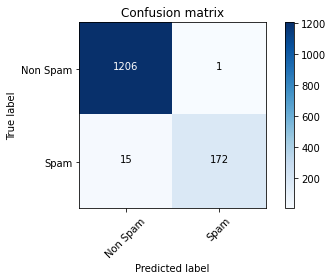

In [84]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=False,
                      title='Confusion matrix')

Normalized confusion matrix
[[9.99171500e-01 8.28500414e-04]
 [8.02139037e-02 9.19786096e-01]]


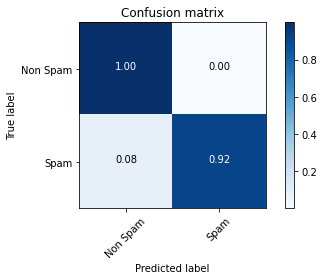

In [86]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=True,
                      title='Confusion matrix')

#UNSUPERVISED CLUSTERING

In [0]:
def get_final_text(stemmed_text):
    final_text=" ".join([word for word in stemmed_text])
    return final_text

In [0]:
X_train['final_text']=X_train.Lemmatized_text.apply(lambda row : get_final_text(row))
X_test['final_text']=X_test.Lemmatized_text.apply(lambda row : get_final_text(row))

In [109]:
X_train

,Message,modi_message,tokenized_msg,stopwords_removed,singledig_removed,stemmed_text,Lemmatized_text,final_text
4925,we can go 4 e normal pilates after our intro...,we can go 4 e normal pilates after our intro,"[we, can, go, 4, e, normal, pilates, after, ou...","[go, 4, e, normal, pilates, intro]","[go, normal, pilates, intro]","[go, normal, pilat, intro]","[go, normal, pilat, intro]",go normal pilat intro
2349,that seems unnecessarily affectionate,that seems unnecessarily affectionate,"[that, seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seems, unnecessarily, affectionate]","[seem, unnecessarili, affection]","[seem, unnecessarili, affection]",seem unnecessarili affection
1396,thats cool! i am a gentleman and will treat yo...,thats cool i am a gentleman and will treat you...,"[thats, cool, i, am, a, gentleman, and, will, ...","[thats, cool, gentleman, treat, dignity, respect]","[thats, cool, gentleman, treat, dignity, respect]","[that, cool, gentleman, treat, digniti, respect]","[that, cool, gentleman, treat, digniti, respect]",that cool gentleman treat digniti respect
475,nice line said by a broken heart- plz don't cu...,nice line said by a broken heart plz dont cum ...,"[nice, line, said, by, a, broken, heart, plz, ...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...","[nice, line, said, broken, heart, plz, dont, c...",nice line said broken heart plz dont cum time ...
1473,just sent you an email – to an address with in...,just sent you an email – to an address with in...,"[just, sent, you, an, email, to, an, address, ...","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]","[sent, email, address, incomm, right]",sent email address incomm right
...,...,...,...,...,...,...,...,...
3838,early bird! any purchases yet?,early bird any purchases yet,"[early, bird, any, purchases, yet]","[early, bird, purchases, yet]","[early, bird, purchases, yet]","[earli, bird, purchas, yet]","[earli, bird, purchas, yet]",earli bird purchas yet
423,siva is in hostel aha:-.,siva is in hostel aha,"[siva, is, in, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]","[siva, hostel, aha]",siva hostel aha
3824,please protect yourself from e-threats. sib ne...,please protect yourself from ethreats sib neve...,"[please, protect, yourself, from, ethreats, si...","[please, protect, ethreats, sib, never, asks, ...","[please, protect, ethreats, sib, never, asks, ...","[pleas, protect, ethreat, sib, never, ask, sen...","[plea, protect, ethreat, sib, never, ask, sens...",plea protect ethreat sib never ask sensit info...
1836,* will be september by then!,will be september by then,"[, will, be, september, by, then]","[, september]",[september],[septemb],[septemb],septemb


#Text Analyzinf with TF-IDF

In [0]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(X_train['final_text'].append(X_test['final_text']))

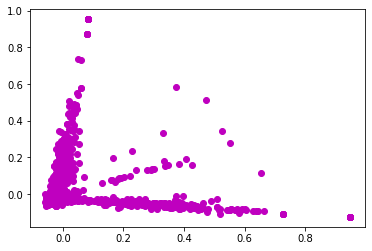

In [111]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

#Top Keywords in the messages

In [0]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [0]:
valu1=0
valu0=0
for numbers in labels:
  if numbers==1:
    valu1+=1
  else:
    valu0+=1

In [116]:
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 6, 10))

  features     score
0   return  0.514868
1   period  0.306619
2   yetund  0.306619
3  januari  0.280826
4      mid  0.272522
5  surpris  0.252776
6    money  0.209085
7      end  0.203445
8     year  0.198549
9    didnt  0.195610


#Top words in all the messages

In [0]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [118]:
print(top_mean_feats(X, features, top_n=10))

  features     score
0       im  0.020115
1       ok  0.019064
2     come  0.015771
3      ill  0.014245
4       ur  0.013168
5     ltgt  0.012627
6     dont  0.012480
7     know  0.012359
8     time  0.012096
9     good  0.011865


#K-Means Clustering

In [0]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

#Top words in each cluster

In [0]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [0]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [0]:
dfs=top_feats_per_cluster(X, np.append(y_train,y_test),features, 0.1,25)

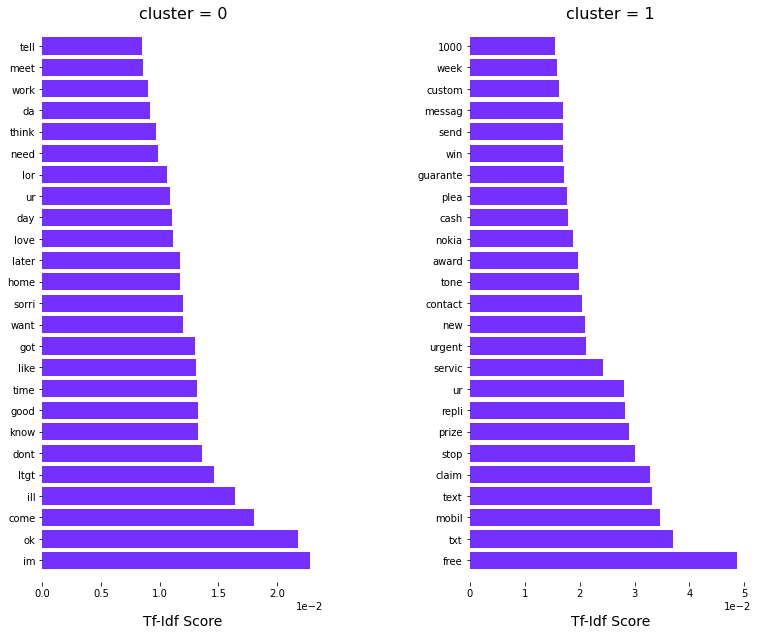

In [123]:
plot_tfidf_classfeats_h(dfs)

Here the cluster 0 represents Ham
and the cluster 1 represents spam. 

From the above figure we could see that spam messages mostly consists of words like prize, cash, free,claim,award etc..

Then going further using this important spam keywords we can further group messages based on the keyword

Where as in the case of ham messages, the top words present are ok, im, home,come which are used in day-day activities